In [2]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://docs.quantum-computing.ibm.com/run/primitives
# result = Sampler().run(circuits).result()
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), Pauli operators (X, Y, Z), and the identity operator (I)
from qiskit.opflow import Zero, One, X, Y, Z, I

# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter



from qiskit import  Aer, transpile, assemble, QuantumRegister, ClassicalRegister, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector, partial_trace

import math

print("Imports Successful")

Imports Successful


# Heisenberg spin Hamiltonian  for N=4

In [50]:
def mag_hamiltonian():
    H=1*((X^X^I) + (Y^Y^I) + (Z^Z^I) + (I^X^X) + (I^Y^Y) + (I^Z^Z)) + (1*(Z^I^I) + (I^Z^I) + (I^I^Z))
    
    return H

def hamiltonian():
    H=((X^X^I) + (Y^Y^I) + (Z^Z^I) + (I^X^X) + (I^Y^Y) + (I^Z^Z))
    return H

In [51]:
def time_evol(t):
    H=hamiltonian()
    U_t=(t*H).exp_i()
    return U_t

def mag_time_evol(t):
    H=mag_hamiltonian()
    U_t=(t*H).exp_i()
    return U_t

In [52]:
time = np.linspace(0,  np.pi, 100)
initial_state = (One^One^One) + (Zero^Zero^Zero)
initial_state=initial_state/2**0.5
#calculating ||<110|U(t)|110>||^2
prob_state=[np.abs((~initial_state @ time_evol(float(t)) @ initial_state).eval())**2 for t in time]
mag_prob_state=[np.abs((~initial_state @ mag_time_evol(float(t)) @ initial_state).eval())**2 for t in time]

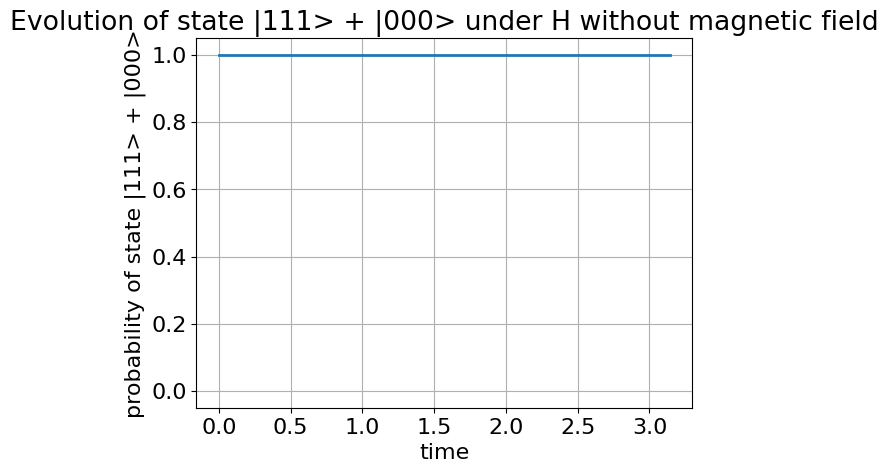

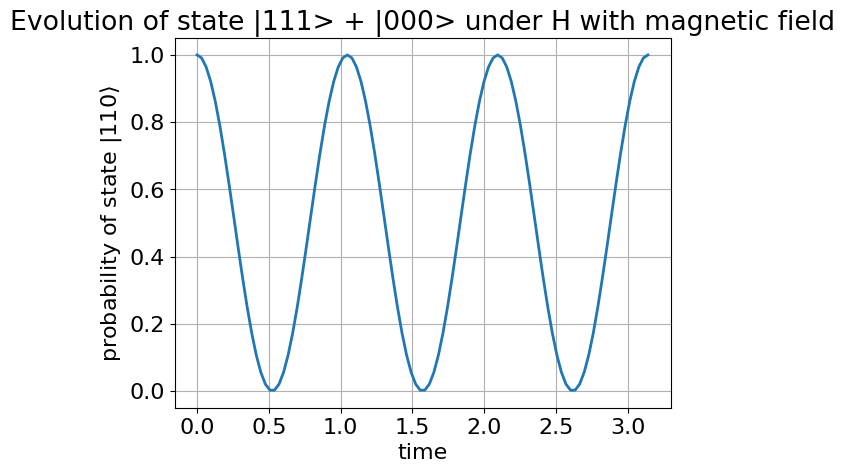

In [95]:
plt.plot(time, prob_state, linewidth=2)
plt.xlabel('time')
plt.ylabel(r'probability of state |111> + |000>')
plt.title(r'Evolution of state |111> + |000> under H without magnetic field')
plt.ylim([-0.05,1.05])
plt.grid()
plt.show()

plt.plot(time, mag_prob_state, linewidth=2)
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state |111> + |000> under H with magnetic field')
plt.ylim([-0.05,1.05])
plt.grid()
plt.show()

# Now lets try to simulate the time evolution of our  system using suzuki-totterization method

In [7]:
#based on the decomposition of the hamiltonian in the report the gates required to simulate the hamiltonian is defined here
t = Parameter('t')

def xx_circuit(t):
 xx_circ=QuantumCircuit(2)
 xx_circ.ry(np.pi/2,[0,1])
 xx_circ.cx(0,1)
 xx_circ.rz(2 * t, 1)
 xx_circ.cnot(0,1)
 xx_circ.ry(-np.pi/2,[0,1])
 
 XX = xx_circ.to_instruction()
 return XX

In [8]:
def yy_circuit(t):
 yy_circ=QuantumCircuit(2)
 yy_circ.rx(np.pi/2,[0,1])
 yy_circ.cx(0,1)
 yy_circ.rz(2 * t, 1)
 yy_circ.cnot(0,1)
 yy_circ.rx(-np.pi/2,[0,1])
 
 YY = yy_circ.to_instruction()
 return YY

In [9]:
def zz_circuit(t):
    zz_circ=QuantumCircuit(2)
    zz_circ.ry(np.pi/2,[0,1])
    zz_circ.cnot(0,1)
    zz_circ.rx(2 * t, 0)
    zz_circ.cnot(0,1)
    zz_circ.ry(-np.pi/2,[0,1])
    
    ZZ = zz_circ.to_instruction()
    return ZZ    


In [10]:
def o_circuit(t):
    o_circ=QuantumCircuit(3)
    o_circ.rx(2*t,0)
    o_circ.rx(2*t,1)
    o_circ.rx(2*t,2)
    O = o_circ.to_instruction()
    return  O

In [114]:
XX = xx_circuit(t)
YY = yy_circuit(t)
ZZ = zz_circuit(t)
O  = o_circuit(t)
tot_evol_time=2.52
num_qubits=3
Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

for i in range(0, num_qubits - 1):
    Trot_qc.append(ZZ, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])

# Convert custom quantum circuit into a gate

Trot_gate = Trot_qc.to_instruction()

In [115]:
XX = xx_circuit(t)
YY = yy_circuit(t)
ZZ = zz_circuit(t)
O  = o_circuit(t)

num_qubits=3
mag_Trot_qr = QuantumRegister(num_qubits)
mag_Trot_qc = QuantumCircuit(mag_Trot_qr, name='mag_Trot')

for i in range(0, num_qubits - 1):
    mag_Trot_qc.append(ZZ, [mag_Trot_qr[i], mag_Trot_qr[i+1]])
    mag_Trot_qc.append(YY, [mag_Trot_qr[i], mag_Trot_qr[i+1]])
    mag_Trot_qc.append(XX, [mag_Trot_qr[i], mag_Trot_qr[i+1]])
mag_Trot_qc.append(O, [mag_Trot_qr[0], mag_Trot_qr[1], mag_Trot_qr[2]])
# Convert custom quantum circuit into a gate

mag_Trot_gate = mag_Trot_qc.to_instruction()

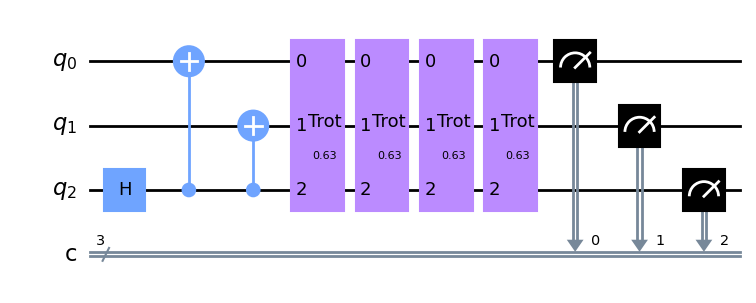

In [116]:
#evolution parameters
trotter_steps=4

final_circ=QuantumCircuit(3,3)

#initial state
final_circ.h(2)
final_circ.cx(2,0)
final_circ.cx(2,1)

mag_final_circ.h(2)
mag_final_circ.cx(2,0)
mag_final_circ.cx(2,1)
    
for i in range(0,trotter_steps):
    final_circ.append(Trot_qc, [0,1,2])


final_circ = final_circ.bind_parameters({t: tot_evol_time/trotter_steps})
 

final_circ.measure(0,0)
final_circ.measure(1,1)
final_circ.measure(2,2)
final_circ.draw() 


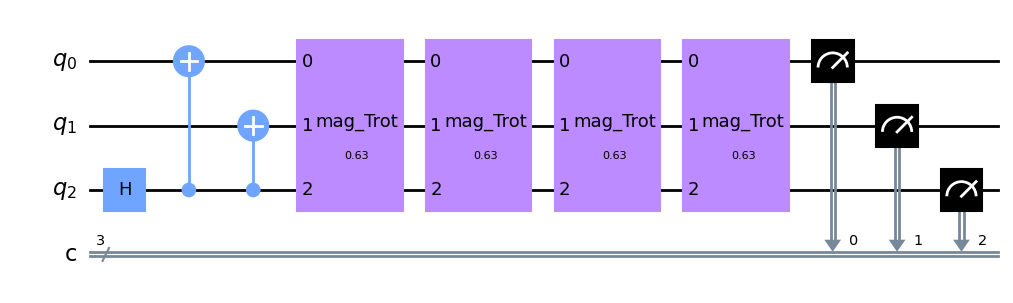

In [117]:
mag_final_circ=QuantumCircuit(3,3)
mag_final_circ.h(2)
mag_final_circ.cx(2,0)
mag_final_circ.cx(2,1)
for i in range(0,trotter_steps):
    mag_final_circ.append(mag_Trot_qc, [0,1,2])

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
mag_final_circ = mag_final_circ.bind_parameters({t: tot_evol_time/trotter_steps})
 

mag_final_circ.measure(0,0)
mag_final_circ.measure(1,1)
mag_final_circ.measure(2,2)
mag_final_circ.draw() 


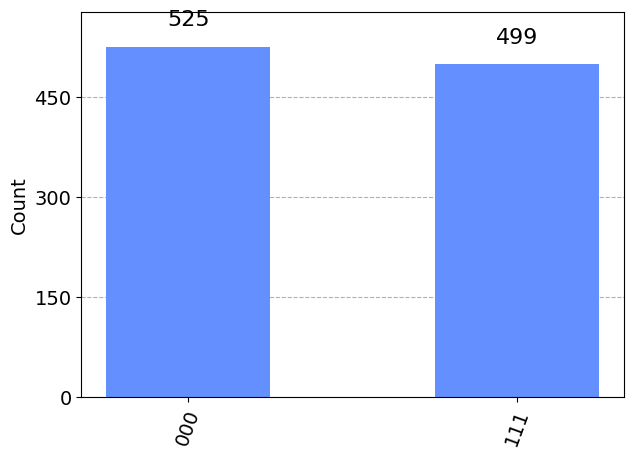

In [118]:
backend = Aer.get_backend('qasm_simulator')
job = execute(final_circ, backend = backend, shots = 1024)

result = job.result()
counts = result.get_counts()

plot_histogram(counts)

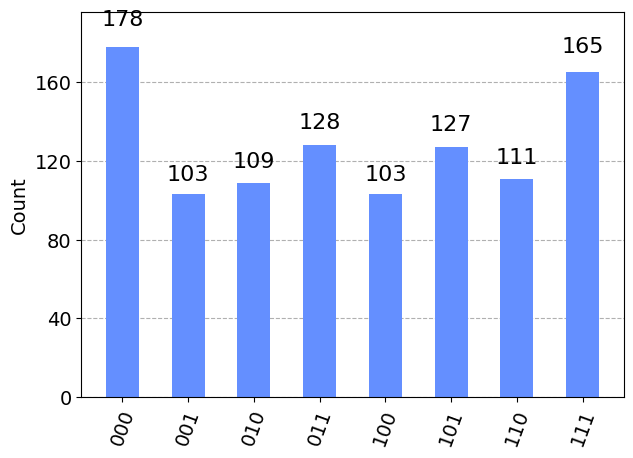

In [119]:
backend = Aer.get_backend('qasm_simulator')
job = execute(mag_final_circ, backend = backend, shots = 1024)

result = job.result()
counts = result.get_counts()

plot_histogram(counts)